Make a pipeline that uses all the variables in the Ames dataset, and then fits Ridge Regression with alpha = 1.

Cross-validate this pipeline and compare the results to the ordinary linear regression.

Then fit the model on the whole dataset and get the coefficients. Make a plot of these coefficients compared to the ones from ordinary linear regression.

In [21]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

In [8]:
# Read the data
ames = pd.read_csv("AmesHousing.csv")

# Get rid of columns with mostly NaN values
good_cols = ames.isna().sum() < 100
ames = ames.loc[:,good_cols]

# Drop other NAs
ames = ames.dropna()

X = ames.drop(["SalePrice", "Order", "PID"], axis = 1)
y = ames["SalePrice"]

In [12]:
ct = ColumnTransformer(
  [
    ("dummify",
    OneHotEncoder(sparse_output = False, handle_unknown='ignore'),
    make_column_selector(dtype_include=object)),
    ("standardize",
    StandardScaler(),
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
)

ridge_pipeline = Pipeline(
  [("preprocessing", ct),
  ("regressor", Ridge(alpha=1))]
)

lr_pipeline = Pipeline(
  [("preprocessing", ct),
  ("regressor", LinearRegression())]
)

ridge_scores = cross_val_score(ridge_pipeline, X, y, cv=5, scoring='neg_mean_squared_error')
linear_scores = cross_val_score(lr_pipeline, X, y, cv=5, scoring='neg_mean_squared_error')

ridge_rmse = np.sqrt(-ridge_scores).mean()
linear_rmse = np.sqrt(-linear_scores).mean()

print("Cross-validated RMSE for Ridge Regression:", ridge_rmse)
print("Cross-validated RMSE for Ordinary Linear Regression:", linear_rmse)

Cross-validated RMSE for Ridge Regression: 28871.91955382137
Cross-validated RMSE for Ordinary Linear Regression: 1636845648652849.2


In [26]:
ridge_pipeline.fit(X, y)
lr_pipeline.fit(X, y)

# Get coefficients (Ridge and Linear Regression)
ridge_coefs = ridge_pipeline.named_steps['regressor'].coef_
linear_coefs = lr_pipeline.named_steps['regressor'].coef_

In [30]:
len(ridge_coefs), len(linear_coefs)

(254, 254)

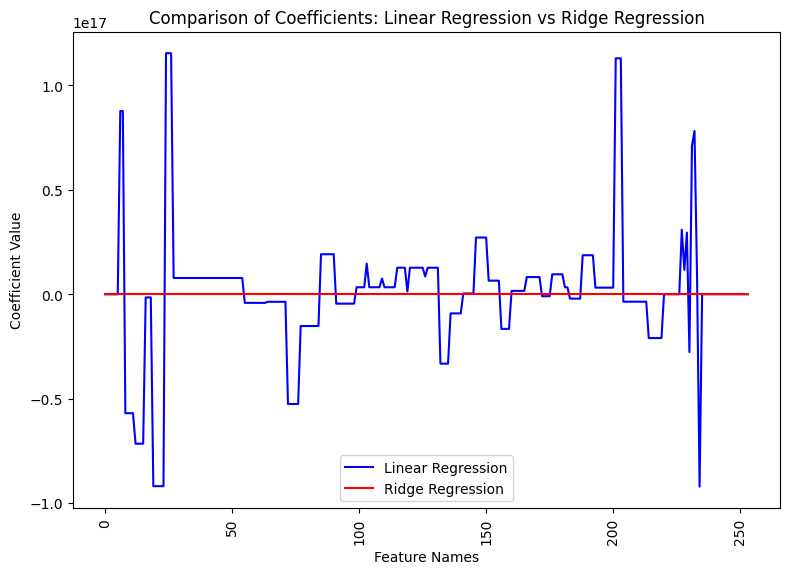

In [32]:
# Plot the coefficients
plt.figure(figsize=(8, 6))
plt.plot(linear_coefs, label="Linear Regression", color='blue')
plt.plot(ridge_coefs, label="Ridge Regression", color='red')
plt.xticks(rotation=90)
plt.xlabel("Feature Names")
plt.ylabel("Coefficient Value")
plt.title("Comparison of Coefficients: Linear Regression vs Ridge Regression")
plt.legend()
plt.tight_layout()
plt.show()

Using the same pipeline as previously, perform tuning on alpha.

You should always try alpha values on a log scale; that is, don’t use [1,2,3,4]; instead use something like [0.001, 0.01, 0.1, 1, 10]

In [22]:
alpha_values = [0.001, 0.01, 0.1, 1, 10, 100]
param_grid = {
    'regressor__alpha': alpha_values
}

grid_search = GridSearchCV(ridge_pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X, y)
best_alpha = grid_search.best_params_['regressor__alpha']
best_rmse = np.sqrt(-grid_search.best_score_)
print("Best alpha:", best_alpha)
print("Best Cross-validated RMSE for Ridge Regression:", best_rmse)

Best alpha: 10
Best Cross-validated RMSE for Ridge Regression: 29409.19687650802


Create a LASSO pipeline, and tune alpha.

Fit your best model on the full Ames data, and compare the coefficients to Ridge and OLS

In [33]:
lasso_pipeline = Pipeline(steps=[
    ('preprocessor', ct),
    ('regressor', Lasso(max_iter=10000))
])

param_grid = {
    'regressor__alpha': alpha_values
}
lasso_grid_search = GridSearchCV(lasso_pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
lasso_grid_search.fit(X, y)

best_lasso_alpha = lasso_grid_search.best_params_['regressor__alpha']
best_lasso_model = lasso_grid_search.best_estimator_

print("Best alpha for LASSO:", best_lasso_alpha)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


KeyboardInterrupt: 